In [ ]:
#program : predicting milk grade with ML

In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import classification_report
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score,KFold



In [ ]:
from google.colab import drive

In [ ]:
df=pd.read_csv("/content/Milk Grading (1).csv")
df.head()

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.6,35,1,0,1,0,254,1.0
1,6.6,36,0,1,0,1,253,1.0
2,8.5,70,1,1,1,1,246,0.0
3,9.5,34,1,1,0,1,255,0.0
4,6.6,37,0,0,0,0,255,0.5


In [ ]:
df.isnull().sum()

pH            0
Temprature    0
Taste         0
Odor          0
Fat           0
Turbidity     0
Colour        0
Grade         0
dtype: int64

In [ ]:
df.shape

(1059, 8)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le =LabelEncoder()
grade=le.fit_transform(df['Grade'])
df['Grade']=grade
df.head()

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.6,35,1,0,1,0,254,2
1,6.6,36,0,1,0,1,253,2
2,8.5,70,1,1,1,1,246,0
3,9.5,34,1,1,0,1,255,0
4,6.6,37,0,0,0,0,255,1


In [ ]:
df2=df.copy(deep=True)
#Getting Outliers Percentage for all columns
for k,v in df2.items():
  q1=v.quantile(0.25)
  q3=v.quantile(0.75)
  iqr=q3-q1
  vcol=v[(v<=q1-1.5*iqr)|(v>=q3+1.5*iqr)]
  perc=np.shape(vcol)[0]*100.00 / np.shape(df2)[0]
  print(f"{k} Outliers={round(perc,2)}")

pH Outliers=35.79
Temprature Outliers=9.73
Taste Outliers=0.0
Odor Outliers=0.0
Fat  Outliers=0.0
Turbidity Outliers=0.0
Colour Outliers=3.02
Grade Outliers=0.0


In [ ]:
def remoutliers(df_in,col):
  for i in col:
    q1=df_in[i].quantile(0.25)
    q3=df_in[i].quantile(0.75)
    iqr=q3-q1
    fence_low=q1-1.5*iqr
    fence_high=q3+1.5*iqr
    df_out=df_in.loc[(df_in[i]>fence_low)&(df_in[i]<fence_high)]
    return df_out
df3=remoutliers(df2,['pH'])

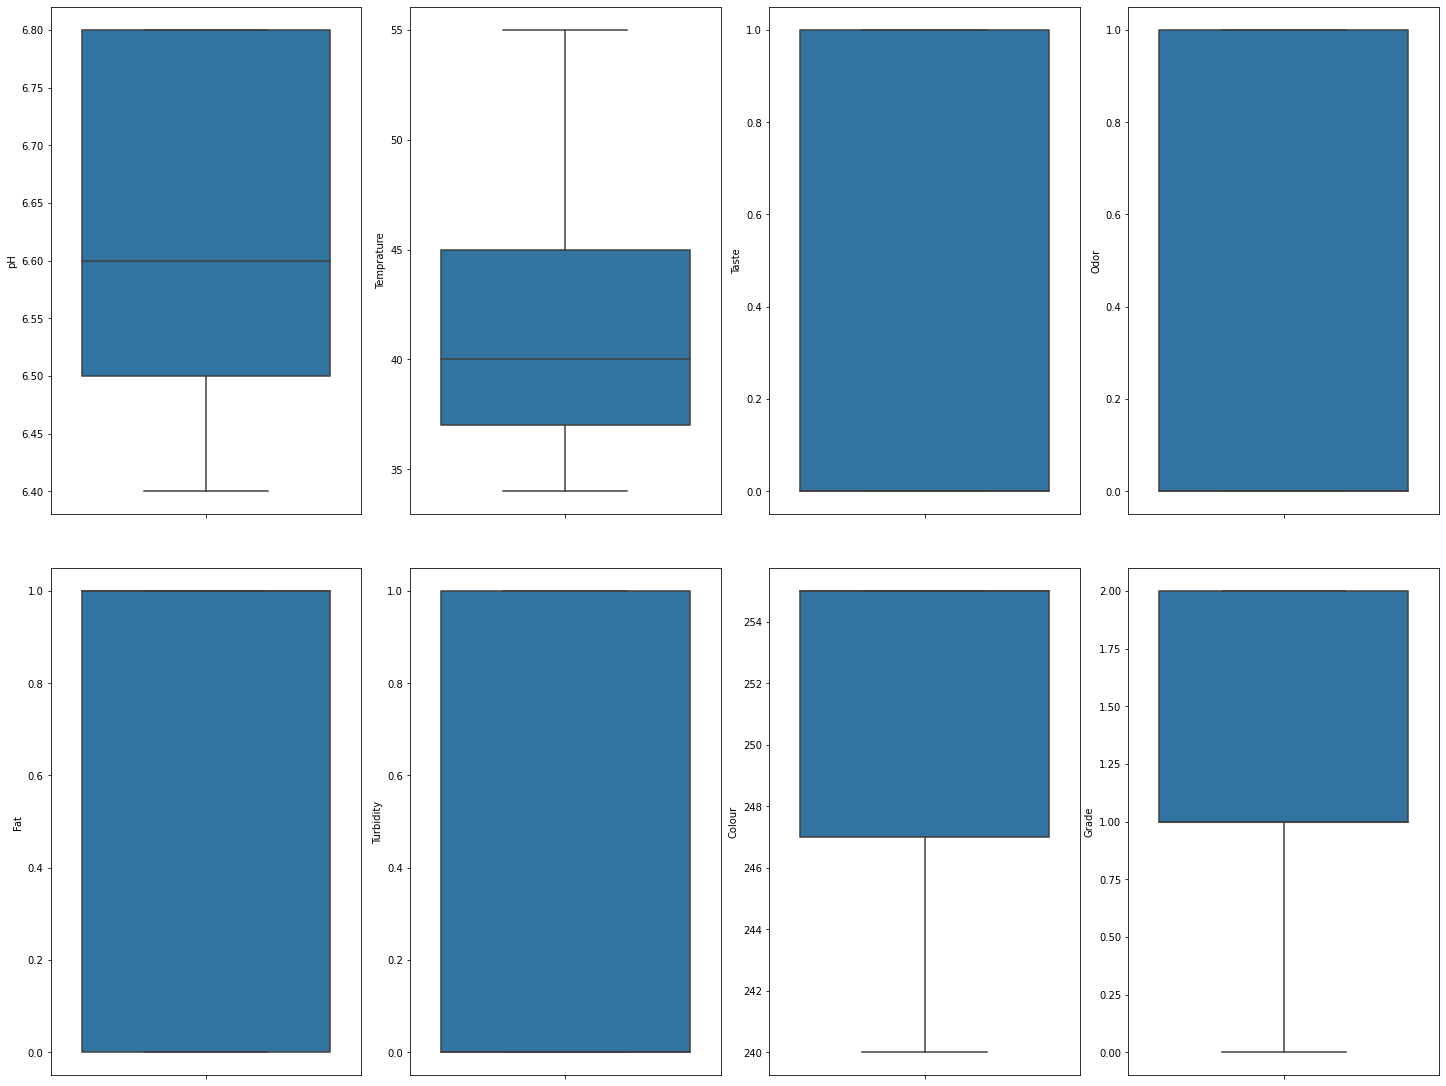

In [ ]:
#visualizations of the outlier for all the columns of boxplot
fig,axs=plt.subplots(ncols=4,nrows=2,figsize=(20,15))
index=0
axs=axs.flatten()
for k,v in df3.items():
  sns.boxplot(y=k,data=df3,ax=axs[index])
  index+=1
plt.tight_layout(pad=0.4,w_pad=0.5,h_pad=5.0)


In [ ]:
ct=make_column_transformer(
    (MinMaxScaler(),['pH','Temprature','Colour'])
)


In [ ]:
X=df3.drop('Grade',axis=1)
Y=df3['Grade']


In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)


In [ ]:
ct.fit(X_train)
X_train_normal=ct.transform(X_train)
X_test_normal=ct.transform(X_test)

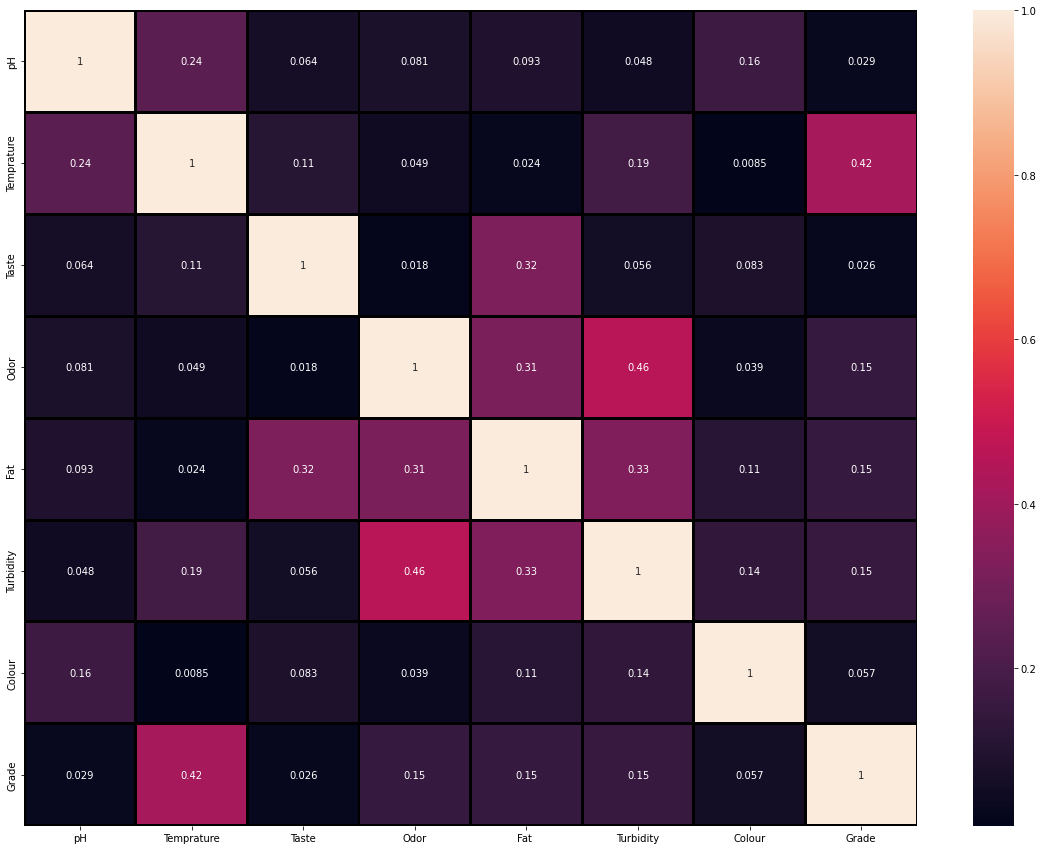

In [ ]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr().abs(),annot=True,linecolor='black', linewidths=2)


**Random Forest Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rnfr=RandomForestClassifier(n_estimators=20)


In [ ]:
rnfr.fit(X_train_normal,Y_train)
y_rn_predict=rnfr.predict(X_test_normal)
accuracy_random=accuracy_score(Y_test,y_rn_predict)
print("Accuracy of the model(Random Forest) is:",round(accuracy_random*100))


Accuracy of the model(Random Forest) is: 90


In [ ]:
confusion_matrix(Y_test,y_rn_predict)


array([[ 6,  1,  0],
       [ 0, 78,  8],
       [ 0,  4, 39]])

In [ ]:
#using K-fold cross Validation for prediction using random forest
kfold=KFold(n_splits=5,random_state=72,shuffle=True)
scores = cross_val_score(rnfr,X,Y,cv=kfold)
print('Cross validation accuracies:',scores*100)
print(f"Overall Accuracy by using KFold method is {round(scores.mean()*100)}")



Cross validation accuracies: [ 99.26470588  99.26470588 100.          99.26470588 100.        ]
Overall Accuracy by using KFold method is 100


Logistic Regression model

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr=LogisticRegression(max_iter=10000)
lr.fit(X_train_normal,Y_train)
testprediction=lr.predict(X_test_normal)
accuracy_lr= accuracy_score(Y_test,testprediction)
print("Accuracy of the model is:",round(accuracy_lr)*100)

Accuracy of the model is: 100


In [ ]:
confusion_matrix(Y_test,testprediction)

array([[ 5,  1,  1],
       [ 0, 76, 10],
       [ 0, 28, 15]])

In [ ]:
scores_lr=cross_val_score(lr,X,Y,cv=kfold)
print("Cross validation accuracies:",scores_lr*100)
print("Overall Accuracy by using KFold method is",round(scores_lr.mean()*100))

Cross validation accuracies: [98.52941176 93.38235294 95.58823529 88.23529412 97.05882353]
Overall Accuracy by using KFold method is 95


K-nearest Neighbours (KNN) Model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier 


In [ ]:
from math import sqrt 
sqrt(len(Y_test))


11.661903789690601

In [ ]:
knn=KNeighborsClassifier(n_neighbors=11,p=2,metric='euclidean')
knn.fit(X_train_normal,Y_train)
test_predictionknn=knn.predict(X_test_normal)
accuracy_knn=accuracy_score(Y_test,test_predictionknn)
print("Accuracy of the model is:",round(accuracy_knn)*100)

Accuracy of the model is: 100


In [ ]:
confusion_matrix(Y_test,test_predictionknn)

array([[ 6,  1,  0],
       [ 0, 83,  3],
       [ 0, 14, 29]])

In [ ]:
scores_knn=cross_val_score(knn,X,Y,cv=kfold)
print("cross validation accuracies:",scores_knn*100)
print("Overall accuracy by using Kfold method:",round(scores_knn.mean()*100))

cross validation accuracies: [98.52941176 97.05882353 99.26470588 94.85294118 96.32352941]
Overall accuracy by using Kfold method: 97


SVM - RBF


In [ ]:
from sklearn.svm import SVC

In [ ]:
svm_rbf=SVC(kernel='rbf')
svm_rbf.fit(X_train_normal,Y_train)
test_predict_svc=svm_rbf.predict(X_test_normal)
accuracy_svm=accuracy_score(Y_test,test_predict_svc)
print("Accuracy of the model is:",round(accuracy_svm)*100)

Accuracy of the model is: 100


In [ ]:
confusion_matrix(Y_test,test_predict_svc)

array([[ 6,  1,  0],
       [ 0, 62, 24],
       [ 0,  2, 41]])

In [ ]:
scores_svc=cross_val_score(svm_rbf,X,Y,cv=kfold)
print("Cross validation accuracies:",scores_svc*100)
print("Overal accuracy using kfold:",round(scores_svc.mean()*100))

Cross validation accuracies: [61.02941176 57.35294118 55.88235294 51.47058824 49.26470588]
Overal accuracy using kfold: 55


After going through all the models accuracy, we can find that Random forest model is the best fit model for the prediction of the given problem milk_quality in normal and cross validation (k_fold) 